# A Review of Multitaper Spectral Analysis
Behtash Babadi, Emry N. Brown

In this notebook I will follow the review on the multitaper approach for PSD estimation of sos processes according to the article in the title

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotly.offline import iplot
from plotly import graph_objs as go
import plotly
# import plotly.express as px
import scipy.signal
import spectrum
%matplotlib inline

## AR process
simulate autoregressive process that we will use across the review

In [2]:
xk = np.array([3.9515, -7.8885, 9.7340, -7.7435, 3.8078, -0.9472])
vk_mu = 0 # random precoess mean
vk_sigma = 1 # random process variance
l = 1 # time interval

generate sample segment accoring to this process

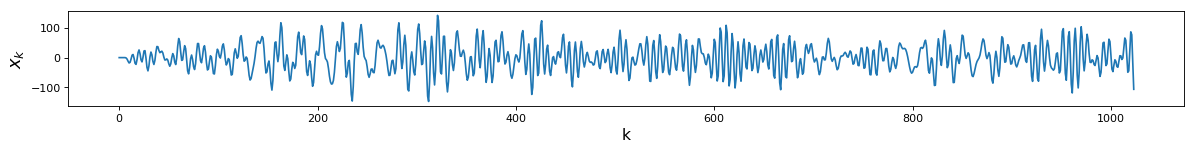

In [3]:
n = 1024
x = np.zeros(n)
vk = np.random.normal(vk_mu, vk_sigma, n)
for i in range(len(xk)+1,n):
    x[i] = vk[i]+np.sum(xk*x[i-1:i-len(xk)-1:-1])
    
fig=plt.figure(figsize=(18, 16), dpi= 80)
plt.plot(x), plt.xlabel('k', fontsize=14), plt.ylabel('$x_k$', fontsize=16)
fig.axes[0].set_aspect(0.3)

Text(0, 0.5, 'S(f)[dB]')

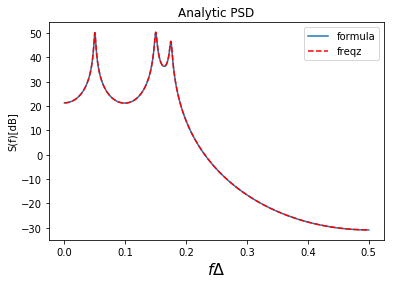

In [4]:
fl = np.linspace(0,0.5,1024)
k = np.arange(len(xk))+1
Sf = vk_sigma**2/np.abs(-1+np.sum(xk[:,np.newaxis]*np.exp(-2j*np.pi*k[:,np.newaxis]*fl[np.newaxis,:]),axis=0))**2
plt.plot(fl,10*np.log10(Sf), label='formula')
[w,H] = scipy.signal.freqz(1, np.append(-1,xk), 1024)
Hp = plt.plot(w/np.pi/2, 20*np.log10(abs(H)),'--r',label='freqz')
plt.title('Analytic PSD')
plt.legend()
plt.xlabel('$f\Delta$', fontsize=16)
plt.ylabel('S(f)[dB]')

## The Periodogram
estimate S(f) by the fourier transform of the signal

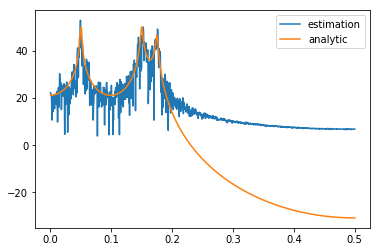

In [5]:
fl = np.linspace(0,0.5,n)
Sf_est = 1/n*np.abs(np.sum(x[:,np.newaxis]*np.exp(-2j*np.pi*np.arange(len(x))[:,np.newaxis]*fl[np.newaxis,:]),axis=0))**2
plt.plot(fl, 10*np.log10(Sf_est),label='estimation')
plt.plot(fl,10*np.log10(Sf), label='analytic')
plt.legend()

The estimation is different from the analytic, it can be shown that the expected value of the estimator is as convollution of the true PSD with Fejer kernel

Text(0.5, 1.0, 'Fejer kernel')

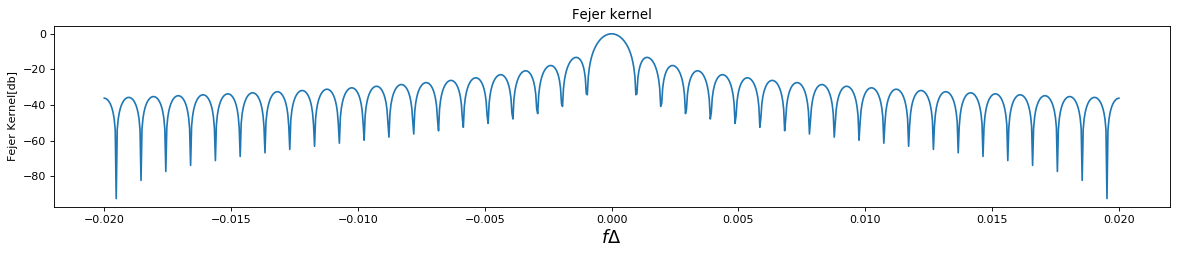

In [6]:
fl = np.linspace(-0.02,0.02,1024)
D2N_fl = (np.sin(n*np.pi*fl)/np.sin(np.pi*fl)/n)**2
fig=plt.figure(figsize=(18, 3), dpi= 80)
plt.plot(fl, 10*np.log10(D2N_fl))
plt.xlabel('$f\Delta$', fontsize=16)
plt.ylabel('Fejer Kernel[db]')
plt.title('Fejer kernel')

There are "two kinds" of biased - narrow band bias caused by the main lobe and broad-band bias caused by the sidelobes 

## Bias Reduction bia Tapering

Tapering (multiplying with a window) is a common way for tradeoff between the broad-band and the narrow=band bias.

Text(0.5, 1.0, 'Hann window')

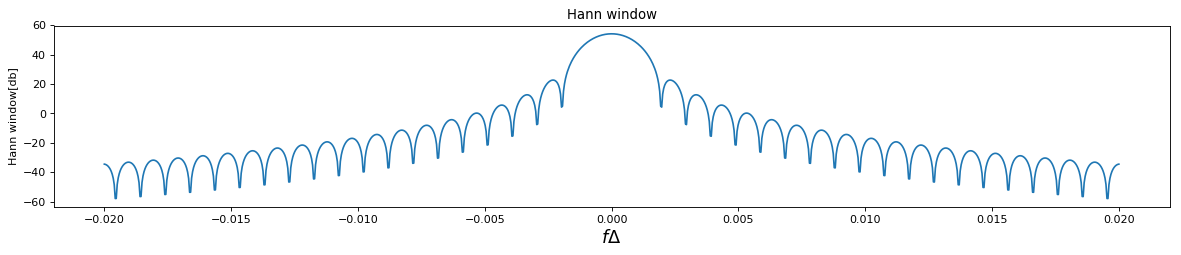

In [7]:
wnd = scipy.signal.windows.hann(n)
fl = np.linspace(-0.02,0.02,n)
wnd_f = np.abs(np.sum(wnd[:,np.newaxis]*np.exp(-2j*np.pi*np.arange(len(x))[:,np.newaxis]*fl[np.newaxis,:]),axis=0))**2
fig=plt.figure(figsize=(18, 3), dpi= 80)
plt.plot(fl, 10*np.log10(wnd_f))
plt.xlabel('$f\Delta$', fontsize=16)
plt.ylabel('Hann window[db]')
plt.title('Hann window')

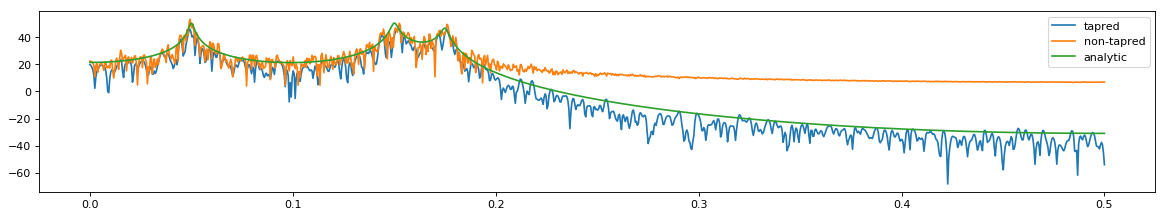

In [8]:
fl = np.linspace(0,0.5,1024)
Sf_hann_est = 1/n*np.abs(np.sum(wnd[:,np.newaxis]*x[:,np.newaxis]*np.exp(-2j*np.pi*np.arange(len(x))[:,np.newaxis]*fl[np.newaxis,:]),axis=0))**2
fig=plt.figure(figsize=(18, 3), dpi= 80)
plt.plot(fl, 10*np.log10(Sf_hann_est), label='tapred')
plt.plot(fl, 10*np.log10(Sf_est), label='non-tapred')
plt.plot(fl,10*np.log10(Sf), label='analytic')

plt.legend()

Another fact to remember about periodogram and tapered estimates is that the variance is high and is not converged to zero when $ N \rightarrow \infty $

## Multitaper spectral estimation

Basically, we look for a set of L orthogonal tapers so the tapred estimatin with them are uncorrelated.
The set of dunctions that minimize a bounding on the bias are the prolate spheriodial sequances (dpss)
Let $ R:=\frac{2\alpha}{N\Delta} $ be the designed spectral resolution.
A good choise of L is
$ L<< \left \lceil{2\alpha}\right \rceil -1 $

0.0078125

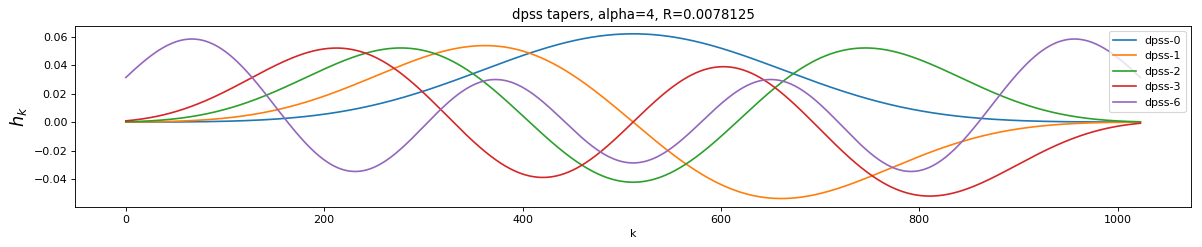

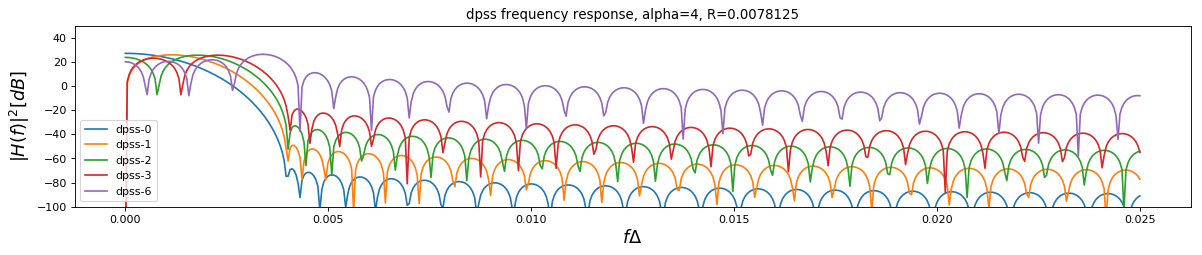

In [9]:
alpha = 4
R = 2*alpha/n/l
kmax=2*alpha-1

display(R)
# dpss = spectrum.dpss(n,alpha,Kmax=kmax)
dpss, lambdas = spectrum.dpss(n,alpha,k=kmax)
dpss = dpss.T
toPlot = [0,1,2,3,kmax-1]
plt.figure(figsize=(18, 3), dpi= 80)
for i in toPlot:
    plt.plot(dpss[i,:], label=f'dpss-{i}')
    plt.xlabel('k')
    plt.ylabel('$h_k$', fontsize=16)
    plt.title(f'dpss tapers, alpha={alpha}, R={R}')
plt.legend()

dpssF = []
L = 4
for i in range(L):
    _, tmpDPSS = scipy.signal.freqz(dpss[i,:])
    dpssF.append(tmpDPSS)
dpssF = np.stack(dpssF, axis=0)    

plt.figure(figsize=(18, 3), dpi= 80)
for i in toPlot:
    w, h = scipy.signal.freqz(dpss[i,:], worN=np.linspace(0,0.05*np.pi,512))
    plt.plot(w/2/np.pi, 20 * np.log10(np.abs(h)),label=f'dpss-{i}')
plt.ylim([-100,50])
plt.xlabel('$f\Delta$', fontsize=16)
plt.ylabel('$ |H(f)|^2[dB] $', fontsize=16)
plt.title(f'dpss frequency response, alpha={alpha}, R={R}')
plt.legend()


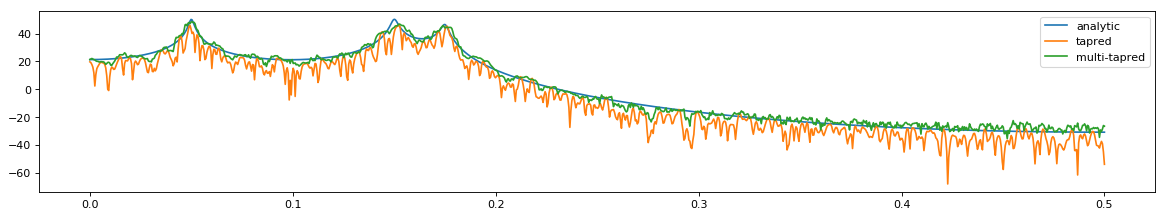

In [10]:
fl = np.linspace(0,0.5,1024)
subFilters = []
L = 4
for i in range(L):
    subFilters.append(np.abs(np.sum(dpss[i,:][:,np.newaxis]*x[:,np.newaxis]*np.exp(-2j*np.pi*np.arange(len(x))[:,np.newaxis]*fl[np.newaxis,:]),axis=0))**2)
multiTaperSf = np.mean(np.stack(subFilters, axis=0),axis=0)
fig=plt.figure(figsize=(18, 3), dpi= 80)
plt.plot(fl,10*np.log10(Sf), label='analytic')
plt.plot(fl, 10*np.log10(Sf_hann_est), label='tapred')
plt.plot(fl, 10*np.log10(multiTaperSf), label='multi-tapred')
plt.legend()